# Discrete Choice Models

In [1]:
import arviz as az
import numpy as np  # For vectorized math operations
import pandas as pd  # For file input/output
import pymc as pm
import pytensor.tensor as pt

from matplotlib import pyplot as plt

In this example we'll examine the technique of discrete choice modelling using a data set from the R `mlogit` package. However we'll pursue a Bayesian approach to estimating the model rather than the MLE methodology used reported in their vigenette. The data set shows household choices over offeres of heating systems in California.  The observations consist of single-family houses in California that were newly built and had central air-conditioning. Five types of systems are considered to have been possible:

 - gas central (gc),
 - gas room (gr),
 - electric central (ec),
 - electric room (er),
 - heat pump (hp).

The data set reports the installation `ic.alt` and operating costs `oc.alt` each household was faced with for each of the five alternatives with some broad demographic information about the household and crucially the choice `depvar`. This is what one choice scenario over the five alternative looks like in the data.


In [2]:
wide_heating_df = pd.read_csv("../data/heating_data_r.csv")
wide_heating_df[wide_heating_df["idcase"] == 1]

,idcase,depvar,ic.gc,ic.gr,ic.ec,ic.er,ic.hp,oc.gc,oc.gr,oc.ec,oc.er,oc.hp,income,agehed,rooms,region
0,1,gc,866.0,962.64,859.9,995.76,1135.5,199.69,151.72,553.34,505.6,237.88,7,25,6,ncostl


The core idea of these kinds of models is to conceive of this as a choice over options with attached latent utility. The utility ascribed to each option is viewed as a linear combination of the attributes for each option, which drives the probability of choosing amongst each option. For each $j$ in all the alternatives $Alt$ which is assumed to take a Gumbel distribution. 
$$ \mathbf{U} \sim Gumbel $$

$$ \begin{pmatrix}
u_{gc}   \\
u_{gr}   \\
u_{ec}   \\
u_{gr}   \\
u_{hp}   \\
\end{pmatrix} =  \begin{pmatrix}
gc_{ic} & gc_{oc}  \\
gr_{ic} & gr_{oc}  \\
ec_{ic} & ec_{oc}  \\
gr_{ic} & gr_{oc}  \\
hp_{ic} & hp_{oc}  \\
\end{pmatrix} \begin{pmatrix}
\beta_{ic}   \\
\beta_{oc}   \\
\end{pmatrix}  $$

This assumption proves to be mathematically convenient because the difference between two Gumbel distributions can be modelled as a logistic function, meaning we can model a contrast difference among multiple alternatives with the softmax function: 

$$ \text{softmax}(u)_{j} = \frac{\exp(u_{j})}{\sum_{q=1}^{J}\exp(u_{q})} $$

The model then assumes that decision maker chooses the option that maximises their subjective utility, the individual utility functions can be richly parameterised. The model is identified just when the utility measures of the alternatives are benchmarked against the fixed utility of the "outside good." The last quantity is fixed at 0. 

$$\begin{pmatrix}
u_{gc}   \\
u_{gr}   \\
u_{ec}   \\
u_{gr}   \\
0   \\
\end{pmatrix}
$$

With these constraints applied we can build out conditional random utility model and it's hierarchical variants. Like nearly all subjects in statistics the precise vocabulary for the model specification is overloaded. The conditional logit parameters $\beta$
may be fixed at the level of the individual, but can vary across individuals too. 

### Digression on Data Formats

Discrete choice models are often estimated using a long-data format where each choice scenario is represented with a row per alternative ID and a binary flag denoting the chosen option in each scenario. This data format is recommended for estimating these kinds of models in `stan` and in `pylogit`. The reason for doing this is that once the columns `installation_costs` and `operating_costs` have been pivoted in this fashion it's easier to include them in matrix calculations. 



In [3]:
long_heating_df = pd.read_csv("../data/long_heating_data.csv")
long_heating_df[long_heating_df["idcase"] == 1]

,Unnamed: 0,idcase,alt_id,choice,depvar,income,agehed,rooms,region,installation_costs,operating_costs
0,0,1,1,1,gc,7,25,6,ncostl,866.00,199.69
1,1,1,2,0,gc,7,25,6,ncostl,962.64,151.72
2,2,1,3,0,gc,7,25,6,ncostl,859.90,553.34
3,3,1,4,0,gc,7,25,6,ncostl,995.76,505.60
4,4,1,5,0,gc,7,25,6,ncostl,1135.50,237.88


## The Basic Model

We will show here how to incorporate the random utility specifications in PyMC. 

Sampling: [beta_ic, beta_oc, y_cat]
/Users/nathanielforde/mambaforge/envs/pymc_examples_new/lib/python3.9/site-packages/pymc/sampling/mcmc.py:243: UserWarning: Use of external NUTS sampler is still experimental
  warnings.warn("Use of external NUTS sampler is still experimental", UserWarning)


Compiling...
Compilation time =  0:00:01.115453
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time =  0:00:02.158516
Transforming variables...
Transformation time =  0:00:00.403817
Computing Log Likelihood...


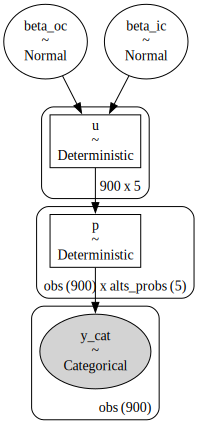

In [4]:
N = wide_heating_df.shape[0]
observed = pd.Categorical(wide_heating_df["depvar"]).codes
coords = {
    "alts_probs": ["ec", "er", "gc", "gr", "hp"],
    "obs": range(N),
}

with pm.Model(coords=coords) as model:
    beta_ic = pm.Normal("beta_ic", 0, 1)
    beta_oc = pm.Normal("beta_oc", 0, 1)

    ## Construct Utility matrix and Pivot
    u0 = beta_ic * wide_heating_df["ic.ec"] + beta_oc * wide_heating_df["oc.ec"]
    u1 = beta_ic * wide_heating_df["ic.er"] + beta_oc * wide_heating_df["oc.er"]
    u2 = beta_ic * wide_heating_df["ic.gc"] + beta_oc * wide_heating_df["oc.gc"]
    u3 = beta_ic * wide_heating_df["ic.gr"] + beta_oc * wide_heating_df["oc.gr"]
    u4 = np.zeros(N)  # Outside Good
    s = pm.Deterministic("u", pm.math.stack([u0, u1, u2, u3, u4]).T)

    ## Apply Softmax Transform
    p_ = pm.Deterministic("p", pm.math.softmax(s, axis=1), dims=("obs", "alts_probs"))

    ## Likelihood
    choice_obs = pm.Categorical("y_cat", p=p_, observed=observed, dims="obs")

    idata_m1 = pm.sample_prior_predictive()
    idata_m1.extend(
        pm.sample(nuts_sampler="numpyro", idata_kwargs={"log_likelihood": True}, random_seed=101)
    )
    idata_m1.extend(pm.sample_posterior_predictive(idata_m1))

pm.model_to_graphviz(model)

In [5]:
idata_m1

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> prior
	> prior_predictive
	> observed_data

In [6]:
summaries = az.summary(idata_m1, var_names=["beta_ic", "beta_oc"])
summaries

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_ic,0.002,0.0,0.002,0.002,0.0,0.0,1870.0,1999.0,1.0
beta_oc,-0.004,0.0,-0.005,-0.004,0.0,0.0,881.0,1105.0,1.0


In the `mlogit` vignette they report how the above model specification leads to inadequate parameter estimates. They note for instance that while the utility scale itself is hard to interpret the value of the ratio of the coefficients is often meaningful because:
$$ U = \beta_{oc}oc + \beta_{ic}ic $$
$$ dU = \beta_{ic} dic + \beta_{oc} doc = 0 \Rightarrow 
-\frac{dic}{doc}\mid_{dU=0}=\frac{\beta_{oc}}{\beta_{ic}}$$

Our parameter estimates differ from the reported estimates, but we agree the model is inadequate. We will show a number of Bayesian model checks to demonstrate this fact, but the main call out is that the parameter values ought to be negative. To interpret the beta coefficient as the increase in utility as a function of a one unit increase in terms of price, so it's strange that an increase in price would increase the utility of generated by the installation even marginally as here. Although we might imagine that some kind of quality assurance comes with price which drives satisfaction. 

We can calculate the marginal rate of substitution as follows:


In [7]:
## marginal rate of substitution for a reduction in installation costs
summaries["mean"]["beta_oc"] / summaries["mean"]["beta_ic"]

-2.0

But being good Bayesians we actually want to calculate the posterior distribution for this statistic.

Text(0.5, 1.0, 'Uncertainty in Marginal Rate of Substitution \n Operating Costs / Installation Costs')

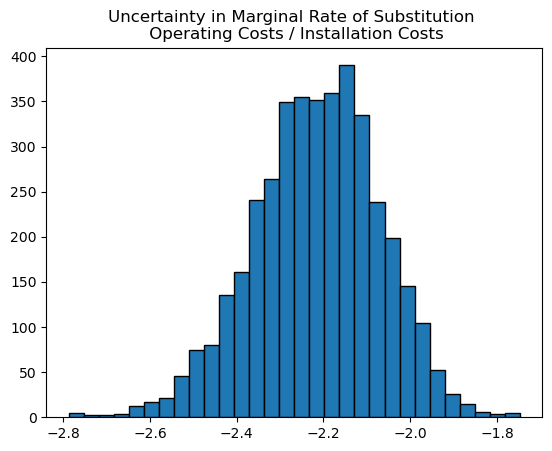

In [8]:
fig, ax = plt.subplots()

ax.hist(
    az.extract(idata_m1["posterior"]["beta_oc"] / idata_m1["posterior"]["beta_ic"])["x"],
    bins=30,
    ec="black",
)
ax.set_title("Uncertainty in Marginal Rate of Substitution \n Operating Costs / Installation Costs")

which suggests that there is almost twice the value accorded to the a unit reduction in recurring operating costs over the one-off installation costs. Whether this is remotely plausible is almost beside the point since the model does not even closely capture the data generating process. 

array([<Axes: xlabel='y_cat / y_cat'>], dtype=object)

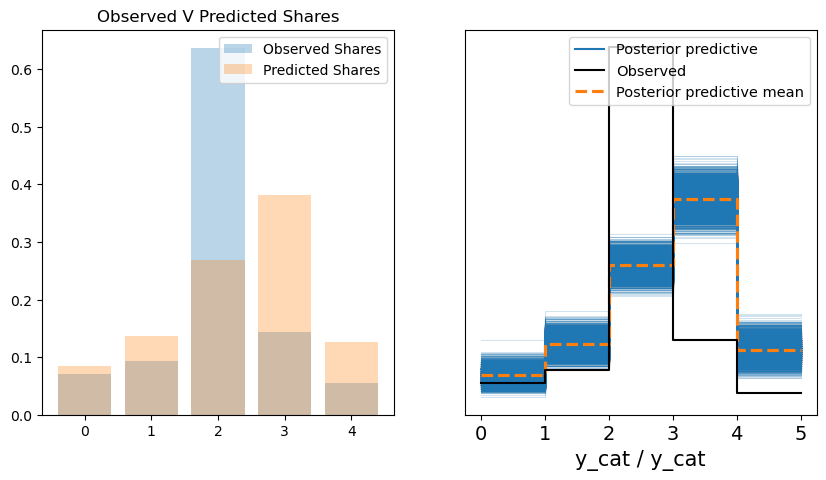

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
ax = axs[0]
counts = wide_heating_df.groupby("depvar")["idcase"].count()
predicted_shares = az.extract(idata_m1, var_names=["p"]).mean(axis=2).mean(axis=0)
ax.bar(range(5), counts / counts.sum(), label="Observed Shares", alpha=0.3)
ax.bar(range(5), predicted_shares, label="Predicted Shares", alpha=0.3)
ax.legend()
ax.set_title("Observed V Predicted Shares")
az.plot_ppc(idata_m1, ax=axs[1])

We can see here that the model is fairly inadequate, and fails quite dramatically to recapture the posterior predictive distribution. 

## Improved Model: Adding Alternative Specific Intercepts

We can address some of the issues with the prior model specification by adding intercept terms for each of the unique alternatives `gr, gc, ec, er`. 

Sampling: [alpha, beta_ic, beta_oc, y_cat]
/Users/nathanielforde/mambaforge/envs/pymc_examples_new/lib/python3.9/site-packages/pymc/sampling/mcmc.py:243: UserWarning: Use of external NUTS sampler is still experimental
  warnings.warn("Use of external NUTS sampler is still experimental", UserWarning)


Compiling...
Compilation time =  0:00:01.358975
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time =  0:00:12.448688
Transforming variables...
Transformation time =  0:00:00.275869
Computing Log Likelihood...


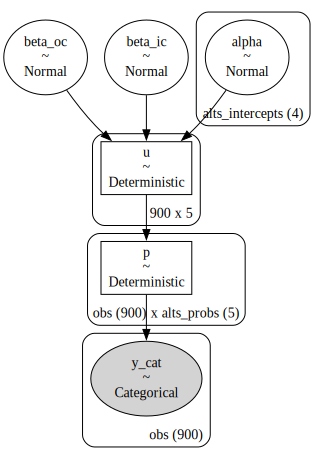

In [10]:
N = wide_heating_df.shape[0]
observed = pd.Categorical(wide_heating_df["depvar"]).codes

coords = {
    "alts_intercepts": ["ec", "er", "gc", "gr"],
    "alts_probs": ["ec", "er", "gc", "gr", "hp"],
    "obs": range(N),
}
with pm.Model(coords=coords) as model_2:
    beta_ic = pm.Normal("beta_ic", 0, 1)
    beta_oc = pm.Normal("beta_oc", 0, 1)
    alphas = pm.Normal("alpha", 0, 1, dims="alts_intercepts")

    ## Construct Utility matrix and Pivot using an intercept per alternative
    u0 = alphas[0] + beta_ic * wide_heating_df["ic.ec"] + beta_oc * wide_heating_df["oc.ec"]
    u1 = alphas[1] + beta_ic * wide_heating_df["ic.er"] + beta_oc * wide_heating_df["oc.er"]
    u2 = alphas[2] + beta_ic * wide_heating_df["ic.gc"] + beta_oc * wide_heating_df["oc.gc"]
    u3 = alphas[3] + beta_ic * wide_heating_df["ic.gr"] + beta_oc * wide_heating_df["oc.gr"]
    u4 = np.zeros(N)  # Outside Good
    s = pm.Deterministic("u", pm.math.stack([u0, u1, u2, u3, u4]).T)

    ## Apply Softmax Transform
    p_ = pm.Deterministic("p", pm.math.softmax(s, axis=1), dims=("obs", "alts_probs"))

    ## Likelihood
    choice_obs = pm.Categorical("y_cat", p=p_, observed=observed, dims="obs")

    idata_m2 = pm.sample_prior_predictive()
    idata_m2.extend(
        pm.sample(nuts_sampler="numpyro", idata_kwargs={"log_likelihood": True}, random_seed=103)
    )
    idata_m2.extend(pm.sample_posterior_predictive(idata_m2))


pm.model_to_graphviz(model_2)

In [11]:
az.summary(idata_m2, var_names=["beta_ic", "beta_oc", "alpha"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_ic,0.001,0.000,-0.000,0.001,0.000,0.000,1215.0,1612.0,1.00
beta_oc,-0.003,0.001,-0.005,-0.001,0.000,0.000,1379.0,1743.0,1.00
alpha[ec],1.039,0.497,0.076,1.936,0.016,0.012,908.0,1054.0,1.00
alpha[er],1.077,0.474,0.216,1.988,0.016,0.012,839.0,991.0,1.00
alpha[gc],2.376,0.309,1.789,2.953,0.011,0.008,814.0,836.0,1.01
alpha[gr],0.733,0.373,-0.031,1.374,0.013,0.009,854.0,947.0,1.01


We can see now how this model performs much better in capturing aspects of the data generating process. 

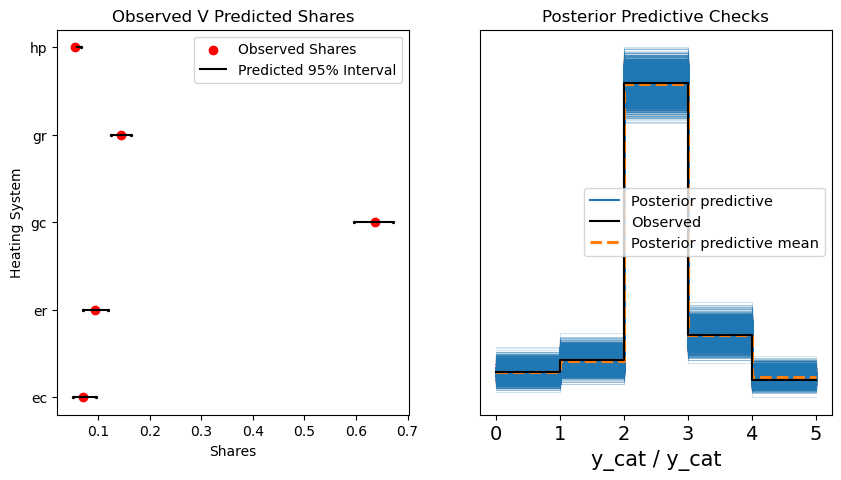

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
ax = axs[0]
counts = wide_heating_df.groupby("depvar")["idcase"].count()
predicted_shares = az.extract(idata_m2, var_names=["p"]).mean(axis=2).mean(axis=0)
ci_lb = np.quantile(az.extract(idata_m2, var_names=["p"]).mean(axis=2), 0.025, axis=0)
ci_ub = np.quantile(az.extract(idata_m2, var_names=["p"]).mean(axis=2), 0.975, axis=0)
ax.scatter(ci_lb, ["ec", "er", "gc", "gr", "hp"], color="k", s=2)
ax.scatter(ci_ub, ["ec", "er", "gc", "gr", "hp"], color="k", s=2)
ax.scatter(
    counts / counts.sum(), ["ec", "er", "gc", "gr", "hp"], label="Observed Shares", color="red"
)
ax.hlines(
    ["ec", "er", "gc", "gr", "hp"], ci_lb, ci_ub, label="Predicted 95% Interval", color="black"
)
ax.legend()
ax.set_title("Observed V Predicted Shares")
az.plot_ppc(idata_m2, ax=axs[1])
axs[1].set_title("Posterior Predictive Checks")
ax.set_xlabel("Shares")
ax.set_ylabel("Heating System");

This model represents a substantial improvement. It's worth pausing to consider how

## Experimental Model: Adding Correlation Structure

We might think that there is a correlation among the alternative goods that we should capture too. 

Sampling: [alpha, beta_ic, beta_income, beta_oc, chol, y_cat]
/Users/nathanielforde/mambaforge/envs/pymc_examples_new/lib/python3.9/site-packages/pymc/sampling/mcmc.py:243: UserWarning: Use of external NUTS sampler is still experimental
  warnings.warn("Use of external NUTS sampler is still experimental", UserWarning)


Compiling...
Compilation time =  0:00:04.186739
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time =  0:00:30.022989
Transforming variables...
Transformation time =  0:00:00.572717
Computing Log Likelihood...


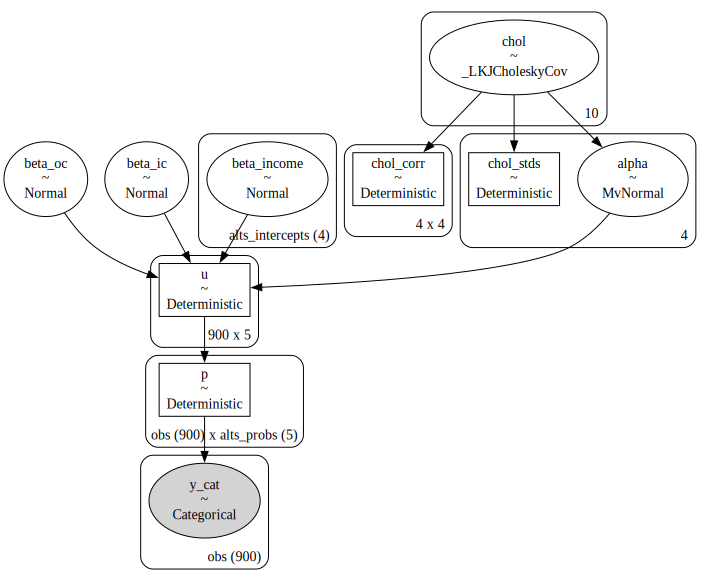

In [13]:
coords = {
    "alts_intercepts": ["ec", "er", "gc", "gr"],
    "alts_probs": ["ec", "er", "gc", "gr", "hp"],
    "obs": range(N),
}
with pm.Model(coords=coords) as model:
    beta_ic = pm.Normal("beta_ic", 0, 1)
    beta_oc = pm.Normal("beta_oc", 0, 1)
    beta_income = pm.Normal("beta_income", 0, 1, dims="alts_intercepts")
    chol, corr, stds = pm.LKJCholeskyCov(
        "chol", n=4, eta=2.0, sd_dist=pm.Exponential.dist(1.0, shape=4)
    )
    alphas = pm.MvNormal("alpha", mu=0, chol=chol)

    u0 = (
        alphas[0]
        + beta_ic * wide_heating_df["ic.ec"]
        + beta_oc * wide_heating_df["oc.ec"]
        + beta_income[0] * wide_heating_df["income"]
    )
    u1 = (
        alphas[1]
        + beta_ic * wide_heating_df["ic.er"]
        + beta_oc * wide_heating_df["oc.er"]
        + beta_income[1] * wide_heating_df["income"]
    )
    u2 = (
        alphas[2]
        + beta_ic * wide_heating_df["ic.gc"]
        + beta_oc * wide_heating_df["oc.gc"]
        + beta_income[2] * wide_heating_df["income"]
    )
    u3 = (
        alphas[3]
        + beta_ic * wide_heating_df["ic.gr"]
        + beta_oc * wide_heating_df["oc.gr"]
        + beta_income[3] * wide_heating_df["income"]
    )
    u4 = np.zeros(N)  # pivot
    s = pm.Deterministic("u", pm.math.stack([u0, u1, u2, u3, u4]).T)

    p_ = pm.Deterministic("p", pm.math.softmax(s, axis=1), dims=("obs", "alts_probs"))
    choice_obs = pm.Categorical("y_cat", p=p_, observed=observed, dims="obs")

    idata_m3 = pm.sample_prior_predictive()
    idata_m3.extend(
        pm.sample(nuts_sampler="numpyro", idata_kwargs={"log_likelihood": True}, random_seed=100)
    )
    idata_m3.extend(pm.sample_posterior_predictive(idata_m3))


pm.model_to_graphviz(model)

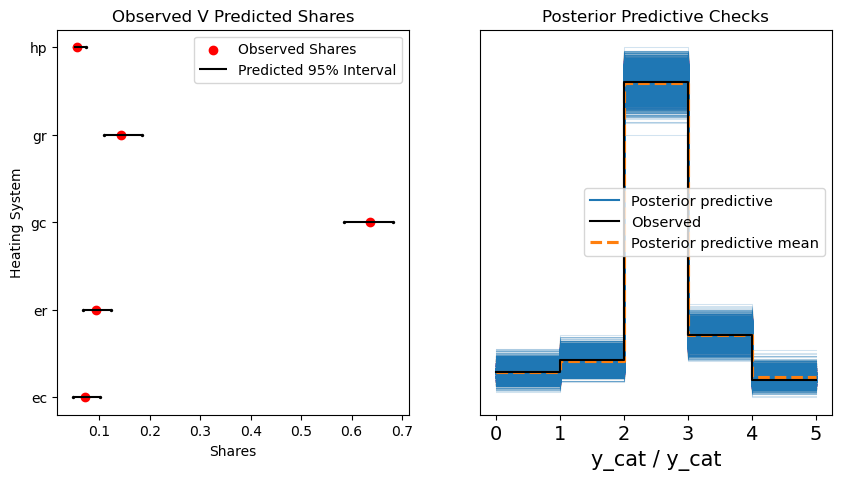

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
ax = axs[0]
counts = wide_heating_df.groupby("depvar")["idcase"].count()
predicted_shares = az.extract(idata_m3, var_names=["p"]).mean(axis=2).mean(axis=0)
ci_lb = np.quantile(az.extract(idata_m3, var_names=["p"]).mean(axis=2), 0.025, axis=0)
ci_ub = np.quantile(az.extract(idata_m3, var_names=["p"]).mean(axis=2), 0.975, axis=0)
ax.scatter(ci_lb, ["ec", "er", "gc", "gr", "hp"], color="k", s=2)
ax.scatter(ci_ub, ["ec", "er", "gc", "gr", "hp"], color="k", s=2)
ax.scatter(
    counts / counts.sum(), ["ec", "er", "gc", "gr", "hp"], label="Observed Shares", color="red"
)
ax.hlines(
    ["ec", "er", "gc", "gr", "hp"], ci_lb, ci_ub, label="Predicted 95% Interval", color="black"
)
ax.legend()
ax.set_title("Observed V Predicted Shares")
az.plot_ppc(idata_m3, ax=axs[1])
axs[1].set_title("Posterior Predictive Checks")
ax.set_xlabel("Shares")
ax.set_ylabel("Heating System");

In [15]:
az.summary(idata_m3, var_names=["beta_income", "beta_ic", "beta_oc", "alpha", "chol_corr"])

/Users/nathanielforde/mambaforge/envs/pymc_examples_new/lib/python3.9/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_income[ec],0.097,0.107,-0.102,0.305,0.004,0.002,936.0,1900.0,1.00
beta_income[er],0.066,0.105,-0.119,0.270,0.004,0.003,839.0,1614.0,1.00
beta_income[gc],0.067,0.087,-0.106,0.220,0.003,0.002,723.0,1321.0,1.00
beta_income[gr],-0.032,0.098,-0.222,0.144,0.003,0.002,808.0,1625.0,1.00
beta_ic,0.000,0.001,-0.001,0.002,0.000,0.000,753.0,914.0,1.00
beta_oc,-0.003,0.002,-0.006,-0.001,0.000,0.000,1436.0,2066.0,1.00
alpha[0],1.035,1.048,-0.421,3.054,0.047,0.033,520.0,1178.0,1.01
alpha[1],1.239,1.075,-0.317,3.243,0.051,0.036,442.0,991.0,1.01
alpha[2],2.372,0.761,1.122,3.771,0.037,0.026,415.0,699.0,1.01
alpha[3],1.201,0.852,-0.095,2.801,0.040,0.028,442.0,1198.0,1.01


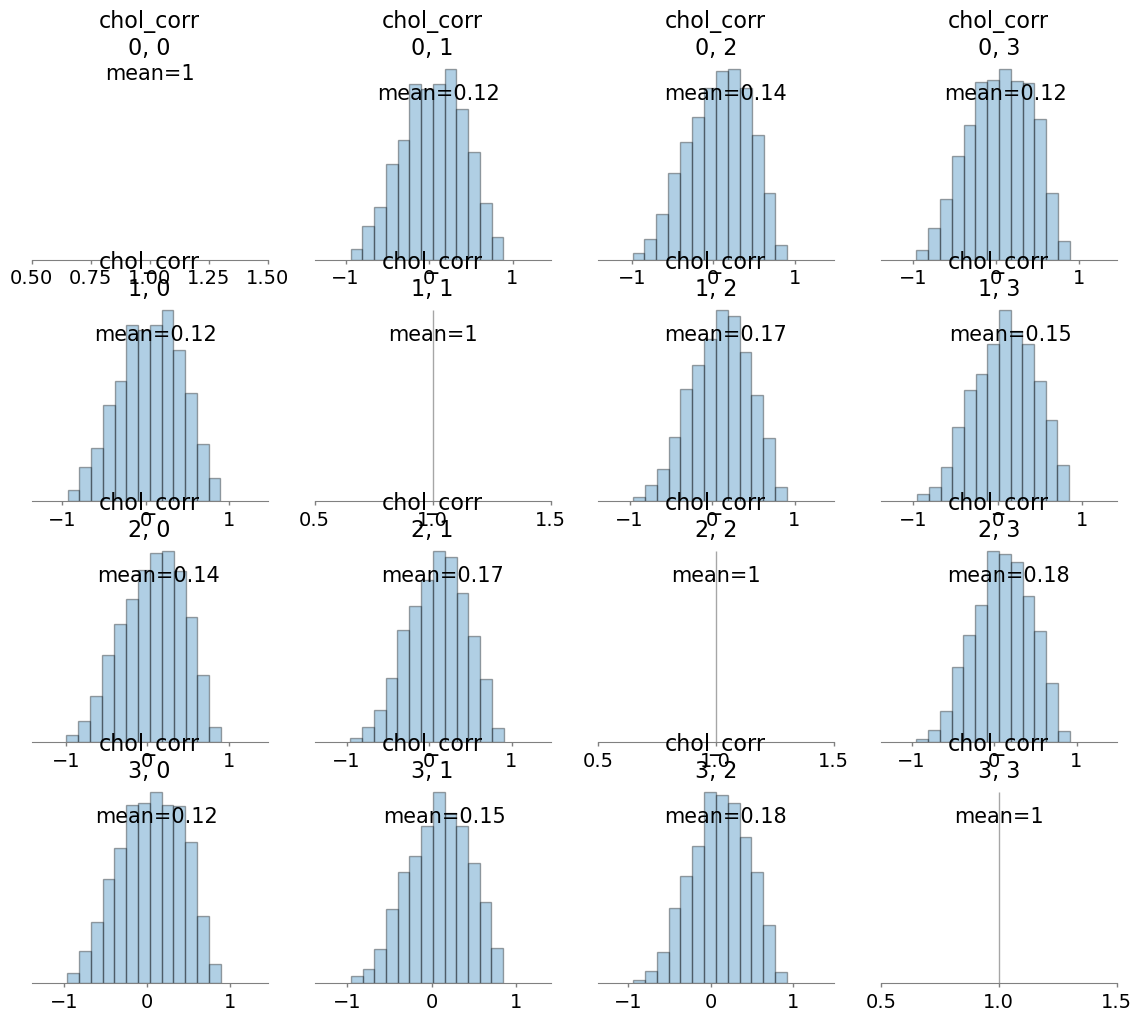

In [16]:
ax = az.plot_posterior(
    idata_m3,
    var_names="chol_corr",
    hdi_prob="hide",
    point_estimate="mean",
    grid=(4, 4),
    kind="hist",
    ec="black",
    figsize=(14, 12),
)

In [17]:
compare = az.compare({"m1": idata_m1, "m2": idata_m2, "m3": idata_m3})
compare

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
m2,0,-1023.600913,4.964848,0.000000,1.000000e+00,27.802378,0.000000,False,log
m3,1,-1025.830915,9.954927,2.230002,1.110223e-16,28.086809,2.070977,False,log
m1,2,-1309.610756,1.196740,286.009843,1.110223e-16,12.933018,22.677610,False,log


<Axes: title={'center': 'Model comparison\nhigher is better'}, xlabel='elpd_loo (log)', ylabel='ranked models'>

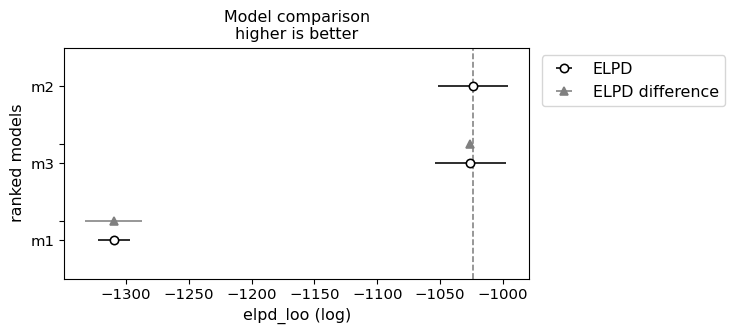

In [18]:
az.plot_compare(compare)

In [19]:
az.extract(idata_m3, var_names=["p"]).mean(axis=2).mean(axis=0)

<xarray.DataArray 'p' (alts_probs: 5)>
array([0.07037874, 0.09204797, 0.63505261, 0.14217707, 0.06034362])
Coordinates:
  * alts_probs  (alts_probs) <U2 'ec' 'er' 'gc' 'gr' 'hp'